# Finding probability of a departure delay

Predicting departure delay is an interesting problem and particularly helpful for airport authorities to find lacunas as well as for cargo transport that happens through the airport. 

In the following approach, the flight schedule and departure times are extracted from the data provided by FlightAware. Every flight has a unique flight ID whch is used to map schedules and departures. Then, the delay for every flight is calculated and all such delays are aggregated over the day on which the flight was scheduled to fly. 

Further exploratory data analysis is done to extract possible features and hypothesize potential factors leading to a day getting delayed. This feature extraction is followed by implementing logistic regression on the data. The data is cross validated to verify accuracy of the model.



Import the necessary packages

In [1]:
import re
import pandas as pd
import numpy as np
import gzip
import os
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#initialize global variables
home_directory = "F:/Study/MS/Transvoyant"
threshold_delay = 800000

Depatures are read from all the gz files. A regular expression extracts the depature time and flightID which will be mapped to schedules data

In [3]:
departure_pattern = re.compile("\"actualDepartureTimestamp\":([0-9]+).*\"flightAwareFlightId\":\"([a-zA-Z0-9-]*)\"")
departures_list = []
def exploreDeparture(name):
    with gzip.open(name, 'rb') as f:
        file_content = f.read()
        matches = departure_pattern.findall(file_content)
        #schedules = np.append(schedules, np.array(matches),0)
        departures_list.extend(matches)

Schedules are too read via regular expression through the json files.

In [4]:
schedule_pattern = re.compile("\"filedDepartureTime\":([0-9]+).*\"flightAwareFlightId\":\"([a-zA-Z0-9-]*)\"")
schedules_list=[]
def exploreSchedule(name):
    with open(name, 'r') as f:
        data = f.read()
        matches = schedule_pattern.findall(data)
        schedules_list.extend(matches)

exploreDir will call the necessary function to extract departures and schedules.

In [5]:
def exploreDir(root):
    for file in os.listdir(root):
        path = os.path.join(root,file)
        if(os.path.isdir(path)):
            print path
            exploreDir(path)
        elif(file.endswith('.gz')):
            #print "Exploring ", file
            exploreDeparture(path)
        elif(file.endswith('.json')):
            exploreSchedule(path)

In [6]:
exploreDir(home_directory)

F:/Study/MS/Transvoyant\Departure
F:/Study/MS/Transvoyant\Departure\dt=2018-01-01
F:/Study/MS/Transvoyant\Departure\dt=2018-01-02
F:/Study/MS/Transvoyant\Departure\dt=2018-01-03
F:/Study/MS/Transvoyant\Departure\dt=2018-01-04
F:/Study/MS/Transvoyant\Departure\dt=2018-01-05
F:/Study/MS/Transvoyant\Departure\dt=2018-01-06
F:/Study/MS/Transvoyant\Departure\dt=2018-01-07
F:/Study/MS/Transvoyant\Departure\dt=2018-01-08
F:/Study/MS/Transvoyant\Departure\dt=2018-01-09
F:/Study/MS/Transvoyant\Departure\dt=2018-01-10
F:/Study/MS/Transvoyant\Departure\dt=2018-01-11
F:/Study/MS/Transvoyant\Departure\dt=2018-01-12
F:/Study/MS/Transvoyant\Departure\dt=2018-01-13
F:/Study/MS/Transvoyant\Departure\dt=2018-01-14
F:/Study/MS/Transvoyant\Departure\dt=2018-01-15
F:/Study/MS/Transvoyant\Departure\dt=2018-01-16
F:/Study/MS/Transvoyant\Departure\dt=2018-01-17
F:/Study/MS/Transvoyant\Departure\dt=2018-01-18
F:/Study/MS/Transvoyant\Departure\dt=2018-01-19
F:/Study/MS/Transvoyant\Departure\dt=2018-01-20
F:/Stu

Next, we create dataframes from the extracted data

In [7]:
schedules = pd.DataFrame(schedules_list, columns=['FiledTime', 'FlightID'])
departures = pd.DataFrame(departures_list, columns=['DepartureTime', 'FlightID'])

In [8]:
schedules.head()

,FiledTime,FlightID
0,1514910900000,SWA1865-1514701572-airline-0570
1,1514911500000,UAL1735-1514701570-airline-0158
2,1514907240000,AAL2379-1514701561-airline-0028
3,1514910600000,ENY3824-1514701561-airline-0512
4,1514907240000,AAL2379-1514701561-airline-0028


In [9]:
departures.head()

,DepartureTime,FlightID
0,1514764786000,CCA1526-1514591700-schedule-0000
1,1514764800000,CSN6125-1514591400-schedule-0000
2,1514764740000,RPA4591-1514528782-airline-0042
3,1514764799000,DAL300-1514528784-airline-0316
4,1514764802000,AAL2478-1514528782-airline-0006


We join schedules and departures by performing a match join on FlightID

In [10]:
del(schedules_list)
del(departures_list)
combined = departures.set_index('FlightID').join(schedules.set_index('FlightID') )

Since NA entries will be of no use in finding delay for a day, we eliminate all the entries with NA row entries.

In [11]:
#combined.head()
#drop na only if it is of the column time
filtered = combined.drop_duplicates(keep='first').dropna(axis=0,how='any')

Next step is to localize times to KDCA times, which happen to be Eastern Standard Time. Delay is also calculated in seconds by finding the difference between filed time and departure time.

In [12]:
filtered['DT_Filed_Time'] = pd.to_datetime(filtered['FiledTime'].astype(long), unit='ms').dt.tz_localize('EST')
filtered['DT_Departure_Time'] = pd.to_datetime(filtered['DepartureTime'].astype(long), unit='ms').dt.tz_localize('EST')
filtered['Delay'] = (filtered['DepartureTime'].astype(long) - filtered['FiledTime'].astype(long))/1000
#cast dataframe datatypes as int


After this, we extract the day and hour to map delays to particular dates. We map the delays to scheduled day and time.

In [13]:
#localize the times to EST
#pd.to_datetime(filtered['Filed Time'].astype(long), unit='ms').dt.tz_localize('EST')

filtered['Hour'] = filtered.DT_Filed_Time.dt.hour
filtered['Day'] = filtered.DT_Filed_Time.dt.day

In [14]:
filtered.tail(20)

,DepartureTime,FiledTime,DT_Filed_Time,DT_Departure_Time,Delay,Hour,Day
FlightID,,,,,,,
VRD1731-1515306382-airline-0332,1515500940000,1515499500000,2018-01-09 12:05:00-05:00,2018-01-09 12:29:00-05:00,1440.0,12,9
VRD1731-1515392764-airline-0199,1515587452000,1515585900000,2018-01-10 12:05:00-05:00,2018-01-10 12:30:52-05:00,1552.0,12,10
VRD1731-1515479193-airline-0455,1515673809000,1515672300000,2018-01-11 12:05:00-05:00,2018-01-11 12:30:09-05:00,1509.0,12,11
VRD1731-1515574790-airline-0477,1515759610000,1515758700000,2018-01-12 12:05:00-05:00,2018-01-12 12:20:10-05:00,910.0,12,12
VRD1731-1515651971-airline-0162,1515846303000,1515845100000,2018-01-13 12:05:00-05:00,2018-01-13 12:25:03-05:00,1203.0,12,13
VRD1731-1515824748-airline-0214,1516019265000,1516017900000,2018-01-15 12:05:00-05:00,2018-01-15 12:27:45-05:00,1365.0,12,15
VRD1737-1514615199-airline-0451,1514851195000,1514850600000,2018-01-01 23:50:00-05:00,2018-01-01 23:59:55-05:00,595.0,23,1
VRD1737-1514701571-airline-0263,1514937906000,1514937000000,2018-01-02 23:50:00-05:00,2018-01-03 00:05:06-05:00,906.0,23,2
VRD1737-1514701571-airline-0263,1514937840000,1514937000000,2018-01-02 23:50:00-05:00,2018-01-03 00:04:00-05:00,840.0,23,2


Some helper functions are defined 

In [15]:
def convertToBoolean(num, comparison, threshold, lower=0, upper=0):
    if comparison=='gt':
        if num > threshold:
            return 1
        return 0
    if comparison=='lt':
        if num <= threshold:
            return 1
        return 0
    if comparison=='eq':
        if num == threshold:
            return 1
        return 0
    if comparison == 'bet':
        if num > lower and num < upper:
            return 1
        return 0

def isDelayed(threshold, value):
    if value > threshold:
        return 1
    return -1


##### We create a dataframe of delays aggregated on Days and create labels based on thereshold values

In [16]:
agg_df = pd.DataFrame(filtered.groupby('Day')[['Delay']].sum())
agg_df.columns=['Sum']
agg_df['labels'] = (agg_df.Sum.apply(lambda x:isDelayed(800000,x)))
agg_df.head()

,Sum,labels
Day,,
1,698323.0,-1
2,794421.0,-1
3,698670.0,-1
4,752925.0,-1
5,739400.0,-1


### Relation between delays and traffic at specific hours.

A heavy traffic during particular hours is likely to cause a delay in departures. Lets explore whether this hypothesis stands true. We first find the peak hours - the hours where most of the flights are scheduled. 

In [17]:
filtered.groupby('Hour')[['Delay']].count().T

Hour,0,1,2,3,4,5,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Delay,738,609,102,502,7,3,77,936,590,1056,560,630,997,630,749,633,855,683,1039,616


Lets assume peak hours be defined as having scheduled more than 900. Thus, we obtain the hours as - 11, 13,16, and 22

In [18]:
peakHrs = [11,13,16,22]
filtered['PeakHourFlights'] = filtered.Hour.isin(peakHrs)

We now aggregate the data and see if the delayed days are in any way proportional to the number of flights in peak hours.

In [19]:
agg_df['PeakHourFlights'] = filtered.groupby('Day')[['PeakHourFlights']].sum()

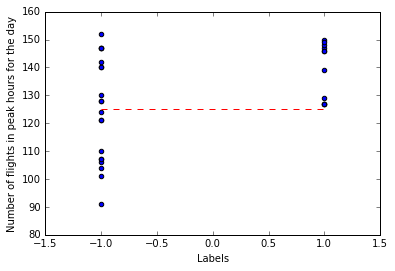

In [20]:
scatterPlot = plt.scatter(agg_df['labels'],agg_df.PeakHourFlights)
plt.xlabel("Labels")
plt.ylabel("Number of flights in peak hours for the day")
arr = np.array([125 for i in range(-1,2)])
plt.plot(range(-1,2), arr, 'r--')
plt.show()

It is observed that if the number of flights in peak hours are less than 125, it is a good indicator of the day not getting delayed. Thus, we convert PeakHours to a boolean parameter based on the number of flights.

In [21]:
agg_df['PeakHourFlights125'] = agg_df.PeakHourFlights.gt(125)

### Relation between total number of flights flying in the day to the delay

We now explore the effect of number of flights on the departure delay. We plot the number of flights against the delay. 

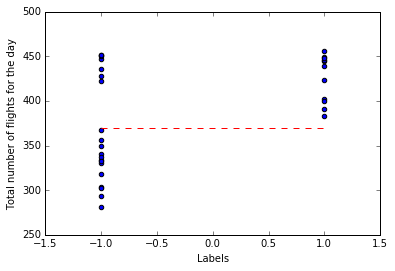

In [22]:
agg_df['NumFlights'] = filtered.groupby('Day')[['Delay']].count()
scatterPlot = plt.scatter(agg_df['labels'],agg_df.NumFlights)
plt.xlabel("Labels")
plt.ylabel("Total number of flights for the day")
arr = np.array([370 for i in range(-1,2)])
plt.plot(range(-1,2), arr, 'r--')
plt.show()

More number of flights do not necessarily indicate a delay, however, lesser number of flights guarantee that the day will not be delayed. Thus, this parameter looks significant.

In [23]:
agg_df['NumFlights370'] = agg_df.NumFlights.gt(370)

Looking more closely, it is very likely that the number of flights in peak hours would correlate to the total number of flights. We look at this trend through a scatterplot. As expected the plot shows a high correlation (94%). We still keep both parameters and would later have their impact tested on the algorithm.

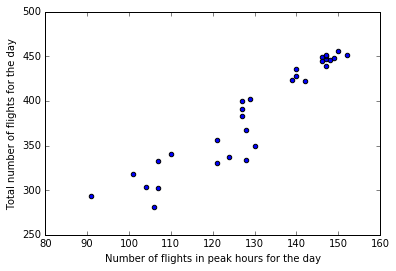

                 PeakHourFlights  NumFlights
PeakHourFlights         1.000000    0.945065
NumFlights              0.945065    1.000000


In [24]:
plt.scatter(agg_df.PeakHourFlights,agg_df.NumFlights)
plt.xlabel("Number of flights in peak hours for the day")
plt.ylabel("Total number of flights for the day")

plt.show()
print pd.concat([agg_df.PeakHourFlights, agg_df.NumFlights],axis=1).corr()

 ### Exploring how the flights which cause more delay impact a day getting delayed
 
 On any given day, the number of flights which get delayed by a certain amount of time are more likely to impact the result of a day getting delayed. We now find the data distribution of delays of each flight

In [25]:
filtered.Delay.describe()

count    12012.000000
mean      2089.062771
std       3004.206907
min      -7080.000000
25%        614.000000
50%       1140.000000
75%       2220.000000
max      70316.000000
Name: Delay, dtype: float64

Lets take the 75th percentile as a benchamrk for the flight being *extra delayed* and find the number of flights which show such behaviour.

In [26]:
filtered['ExtraDelay'] = filtered.Delay.gt(2220)
agg_df['ExtraDelay']=filtered.groupby('Day')[['ExtraDelay']].sum()
agg_df.head()

,Sum,labels,PeakHourFlights,PeakHourFlights125,NumFlights,NumFlights370,ExtraDelay
Day,,,,,,,
1,698323.0,-1,91.0,False,294,False,80.0
2,794421.0,-1,121.0,False,356,False,97.0
3,698670.0,-1,128.0,True,367,False,87.0
4,752925.0,-1,104.0,False,304,False,126.0
5,739400.0,-1,121.0,False,330,False,91.0


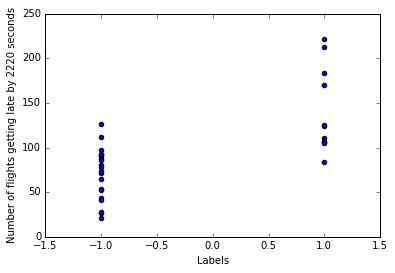

In [27]:
plt.ion()
scatterPlot = plt.scatter(agg_df['labels'],agg_df.ExtraDelay)
plt.xlabel("Labels")
plt.ylabel("Number of flights getting late by 2220 seconds")

plt.show()

The extremes tend to correctly indicate the label. Lets explore whether or not a flight departing early has any impact on the day getting delayed

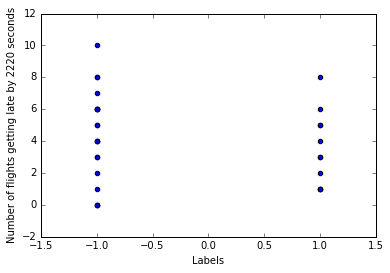

In [28]:
filtered['TooEarly'] = filtered.Delay.lt(-100)
agg_df['TooEarly']=filtered.groupby('Day')[['TooEarly']].sum()
#agg_df.head()


scatterPlot = plt.scatter(agg_df['labels'],agg_df.TooEarly)
plt.xlabel("Labels")
plt.ylabel("Number of flights getting late by 2220 seconds")

plt.show()

A flight departing is not an indicator of delay as expressed from the scatterplot. Thus, we do not include the parameter into the model.

In [29]:
print pd.concat([agg_df.PeakHourFlights, agg_df.NumFlights, agg_df.ExtraDelay],axis=1).corr()

                 PeakHourFlights  NumFlights  ExtraDelay
PeakHourFlights         1.000000    0.945065    0.101975
NumFlights              0.945065    1.000000    0.190471
ExtraDelay              0.101975    0.190471    1.000000


We see that the ExtraDelay parameter show low correlation with NumFlights as well as PeakHourFlights. We thus include it to explain the model.

In [30]:
dataset = agg_df.drop(['TooEarly','Sum'],axis=1)
dataset

,labels,PeakHourFlights,PeakHourFlights125,NumFlights,NumFlights370,ExtraDelay
Day,,,,,,
1,-1,91.0,False,294,False,80.0
2,-1,121.0,False,356,False,97.0
3,-1,128.0,True,367,False,87.0
4,-1,104.0,False,304,False,126.0
5,-1,121.0,False,330,False,91.0
6,-1,107.0,False,302,False,92.0
7,-1,128.0,True,334,False,86.0
8,1,129.0,True,402,True,170.0
9,1,127.0,True,391,True,221.0


We now shuffle the dataset for splitting into training and test part. Model is validated on the test data.

In [263]:
dataset2 = dataset.sample(frac=1)

A logistic regression model is implemented to predict whether or not a day will be delayed with a probability score. Label is 1 if the day is delayed else -1. The problem is mapped to a classification problem wherein based on the features the model is trained to predict whether or not there would be a delay and with what probability. A logistic regression uses a sigmoid function which wil find the probability from the prediction of delay.

In [40]:
from sklearn.linear_model import LogisticRegression

dataset = dataset
train = dataset.iloc[range(24),:]
test = dataset.iloc[range(24,31),:]
train_labels = train['labels']
test_labels = test['labels']
train_data = train.drop('labels',axis=1)
test_data = test.drop('labels',axis=1)

logisticRegr = LogisticRegression()
logisticRegr.fit(train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The accuracy of model ranges from 75 to 85 percent. Since the data points are low, even a one or two inaccurate classifications result in an increased error.

In [41]:
score = logisticRegr.score(test_data, test_labels)
print score

0.857142857143


In [35]:
func = lambda x: 1 if x>0.5 else -1
predicted_labels = np.array([func(x) for x in logisticRegr.predict_proba(test_data)[:,1]])

In [36]:
test_labels

Day
25   -1
26   -1
27   -1
28   -1
29    1
30    1
31   -1
Name: labels, dtype: int64

In [37]:
output = pd.concat([test_labels], axis=1)
output.columns = ['Actual labels']
output["Predicted labels"] = predicted_labels
output["Probability of predicted labels"] = np.max(logisticRegr.predict_proba(test_data), axis=1)

In [38]:
output

,Actual labels,Predicted labels,Probability of predicted labels
Day,,,
25,-1,-1,0.709676
26,-1,-1,0.845989
27,-1,-1,0.951672
28,-1,-1,0.989715
29,1,-1,0.542773
30,1,1,0.590114
31,-1,-1,0.636570


### How is the model validated for accuracy?

Training data is split into two components - the training set and the validation set. Training set forms the basis of training data while the validation set is used to compare hyperparamters and emperical entities that fit the model best.

### Potential other parameters

Analyzing this data gave me a chance to dive deeper into schdules and delays of airplanes. It turns out that weather plays a bigger role than any other factor for a potential delay. (https://aviationsystemsdivision.arc.nasa.gov/publications/more/analysis/mueller_10_02.pdf)

I think a categorical weather data point for every hour, or every six hours would make the model more complete.

### Top 10 airport departures

We extract all the destination airports and group and sort them in descending order

In [42]:
departure_pattern = re.compile("\"destinationAirport\":{\"code\":\"([A-Z]+)\"")
departures_list = []
exploreDir("F:\Study\MS\Transvoyant\Departure")

F:\Study\MS\Transvoyant\Departure\dt=2018-01-01
F:\Study\MS\Transvoyant\Departure\dt=2018-01-02
F:\Study\MS\Transvoyant\Departure\dt=2018-01-03
F:\Study\MS\Transvoyant\Departure\dt=2018-01-04
F:\Study\MS\Transvoyant\Departure\dt=2018-01-05
F:\Study\MS\Transvoyant\Departure\dt=2018-01-06
F:\Study\MS\Transvoyant\Departure\dt=2018-01-07
F:\Study\MS\Transvoyant\Departure\dt=2018-01-08
F:\Study\MS\Transvoyant\Departure\dt=2018-01-09
F:\Study\MS\Transvoyant\Departure\dt=2018-01-10
F:\Study\MS\Transvoyant\Departure\dt=2018-01-11
F:\Study\MS\Transvoyant\Departure\dt=2018-01-12
F:\Study\MS\Transvoyant\Departure\dt=2018-01-13
F:\Study\MS\Transvoyant\Departure\dt=2018-01-14
F:\Study\MS\Transvoyant\Departure\dt=2018-01-15
F:\Study\MS\Transvoyant\Departure\dt=2018-01-16
F:\Study\MS\Transvoyant\Departure\dt=2018-01-17
F:\Study\MS\Transvoyant\Departure\dt=2018-01-18
F:\Study\MS\Transvoyant\Departure\dt=2018-01-19
F:\Study\MS\Transvoyant\Departure\dt=2018-01-20
F:\Study\MS\Transvoyant\Departure\dt=201

In [44]:
destinations = pd.DataFrame(departures_list, columns=['Airports'])
destinations.shape

(2902315, 1)

In [50]:
#filtered.groupby('Day')[['TooEarly']].sum()
grouped_destinations = destinations.groupby('Airports')[['Airports']].count()
grouped_destinations.sort("Airports", ascending=False).head(10)

C:\Users\user\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Airports
Airports,
KATL,35201
KORD,34906
KLAX,28626
KDFW,26855
ZBAA,24303
KDEN,23642
KCLT,21173
ZSPD,19816
ZGGG,18724
